In [1]:
import b3d
import os
import jax.numpy as jnp
import rerun as rr
import jax
import trimesh
import matplotlib.pyplot as plt

In [2]:
PORT = 8812
rr.init("real")
rr.connect(addr=f"127.0.0.1:{PORT}")

In [3]:
def renderer():

    width = 200
    height = 200
    fx = 200.0
    fy = 200.0
    cx = 100.0
    cy = 100.0
    near = 0.001
    far = 16.0
    renderer = b3d.Renderer(width, height, fx, fy, cx, cy, near, far, 1024)
    return renderer

renderer = renderer()

In [4]:
mesh_path = os.path.join(
    b3d.get_root_path(), "assets/shared_data_bucket/025_mug/textured.obj"
)
mesh = trimesh.load(mesh_path)
mesh.vertices = mesh.vertices - mesh.vertices.mean(axis=0)
object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_trimesh(mesh)


object_library = b3d.MeshLibrary.make_empty_library()
occluder = trimesh.creation.box(extents=jnp.array([0.001, 0.1, 0.1]))
occluder_colors = jnp.tile(jnp.array([0.8, 0.8, 0.8])[None,...], (occluder.vertices.shape[0], 1))
object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_object(occluder.vertices, occluder.faces, attributes=occluder_colors)

image_width = 200
image_height = 200
fx = 200.0
fy = 200.0
cx = 100.0
cy = 100.0
near = 0.001
far = 16.0
renderer.set_intrinsics(image_width, image_height, fx, fy, cx, cy, near, far)


/opt/conda/envs/b3d/lib/python3.11/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


In [5]:
from b3d.pose import from_axis_angle

In [6]:
map_trans = jax.vmap(from_axis_angle, (None, 0))

In [7]:
in_place_rots = map_trans(jnp.array([0,0,1]), jnp.linspace(0, jnp.pi/2, 10))

In [8]:

near_pose = b3d.Pose.from_position_and_target(
    jnp.array([0.3, 0.0, 0.0]), jnp.array([0.0, 0.0, 0.0]), jnp.array([0.0, 0.0, 1.0])
).inv()

far_pose = near_pose @ in_place_rots[5]

rgb_near, depth_near = renderer.render_attribute(
    near_pose[None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges,
    object_library.attributes,
)

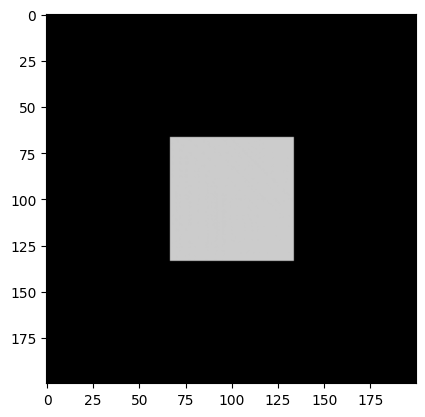

In [9]:
plt.imshow(rgb_near)

In [10]:
rgb_far, depth_far = renderer.render_attribute(
    far_pose[None, ...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges,
    object_library.attributes,
)


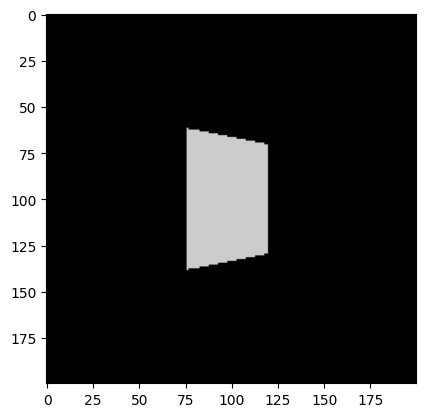

In [11]:
plt.imshow(rgb_far)

In [12]:
def unproject_depth(depth, intrinsics):
    """Unprojects a depth image into a point cloud.

    Args:
        depth (jnp.ndarray): The depth image. Shape (H, W)
        intrinsics (b.camera.Intrinsics): The camera intrinsics.
    Returns:
        jnp.ndarray: The point cloud. Shape (H, W, 3)
    """
    mask = (depth < intrinsics.far) * (depth > intrinsics.near)
    depth = depth * mask + intrinsics.far * (1.0 - mask)
    y, x = jnp.mgrid[: depth.shape[0], : depth.shape[1]]
    x = (x - intrinsics.cx) / intrinsics.fx
    y = (y - intrinsics.cy) / intrinsics.fy
    point_cloud_image = jnp.stack([x, y, jnp.ones_like(x)], axis=-1) * depth[:, :, None]
    return point_cloud_image

In [13]:
# normal visualizer testing

In [14]:
# need to draw posterior samples

In [15]:
## just a flat surface, no cube

In [32]:
def test_patch_orientation_invariance(renderer):

    object_library = b3d.MeshLibrary.make_empty_library()
    occluder = trimesh.creation.box(extents=jnp.array([0.0001, 0.1, 0.1]))
    occluder_colors = jnp.tile(jnp.array([0.8, 0.8, 0.8])[None,...], (occluder.vertices.shape[0], 1))
    object_library = b3d.MeshLibrary.make_empty_library()
    object_library.add_object(occluder.vertices, occluder.faces, attributes=occluder_colors)

    image_width = 200
    image_height = 200
    fx = 200.0
    fy = 200.0
    cx = 100.0
    cy = 100.0
    near = 0.001
    far = 16.0
    renderer.set_intrinsics(image_width, image_height, fx, fy, cx, cy, near, far)

    flat_pose = b3d.Pose.from_position_and_target(
        jnp.array([0.3, 0.0, 0.0]), jnp.array([0.0, 0.0, 0.0]), jnp.array([0.0, 0.0, 1.0])
    ).inv()


    transform_vec = jax.vmap(from_axis_angle, (None, 0))
    in_place_rots = transform_vec(jnp.array([0,0,1]), jnp.linspace(0, jnp.pi/4, 10))
    tilt_pose = flat_pose @ in_place_rots[5]

    rgb_flat, depth_flat = renderer.render_attribute(
        flat_pose[None, ...],
        object_library.vertices,
        object_library.faces,
        object_library.ranges,
        object_library.attributes,
    )

    rgb_tilt, depth_tilt = renderer.render_attribute(
        tilt_pose[None, ...],
        object_library.vertices,
        object_library.faces,
        object_library.ranges,
        object_library.attributes,
    )


    color_error, depth_error = (50.0, 0.01)
    inlier_score, outlier_prob = (4.0, 0.000001)
    color_multiplier, depth_multiplier = (100.0, 1.0)
    model_args = b3d.ModelArgs(
        color_error,
        depth_error,
        inlier_score,
        outlier_prob,
        color_multiplier,
        depth_multiplier,
    )

    from genjax.generative_functions.distributions import ExactDensity
    import genjax


    rr.log("/rgb_flat", rr.Image(rgb_flat))
    rr.log("/rgb_tilt", rr.Image(rgb_tilt))
    rr.log("/depth_flat", rr.DepthImage(depth_flat))
    rr.log("/depth_tilt", rr.DepthImage(depth_tilt))


    area_flat = ((depth_flat / fx) * (depth_flat / fy)).sum()
    area_tilt = ((depth_tilt / fx) * (depth_tilt / fy)).sum()
    print('Depth correction only:\n')
    print('corrected area flat: ' + str(area_flat), 'corrected area tilt: ' + str(area_tilt))

    flat_score = (
        b3d.rgbd_sensor_model.logpdf(
            (rgb_flat, depth_flat), rgb_flat, depth_flat, model_args, fx, fy, 0.0
        )
    )

    tilt_score = (
        b3d.rgbd_sensor_model.logpdf(
            (rgb_tilt, depth_tilt), rgb_tilt, depth_tilt, model_args, fx, fy, 0.0
        )
    )
    print('corrected flat score: ' + str(flat_score), 'corrected tilt score: ' + str(tilt_score))
    print('normalized scores: ' + str(b3d.normalize_log_scores(jnp.array([flat_score, tilt_score]))))
    print('isClose: ' + str(jnp.isclose(flat_score, tilt_score, rtol=0.05)))

In [33]:
test_patch_orientation_invariance(renderer)

Depth correction only:

corrected area flat: 0.010096883 corrected area tilt: 0.0091231605
corrected flat score: -320.92343 corrected tilt score: -331.06445
normalized scores: [9.9996948e-01 3.9427294e-05]
isClose: True


In [34]:
## add back in the cosine invariance structure

In [35]:
## surface normal info from where?

In [36]:
def test_patch_orientation_invariance_norm_correct(renderer):

    object_library = b3d.MeshLibrary.make_empty_library()
    occluder = trimesh.creation.box(extents=jnp.array([0.0001, 0.1, 0.1]))
    occluder_colors = jnp.tile(jnp.array([0.8, 0.8, 0.8])[None,...], (occluder.vertices.shape[0], 1))
    object_library = b3d.MeshLibrary.make_empty_library()
    object_library.add_object(occluder.vertices, occluder.faces, attributes=occluder_colors)

    image_width = 200
    image_height = 200
    fx = 200.0
    fy = 200.0
    cx = 100.0
    cy = 100.0
    near = 0.001
    far = 16.0
    renderer.set_intrinsics(image_width, image_height, fx, fy, cx, cy, near, far)

    flat_pose = b3d.Pose.from_position_and_target(
        jnp.array([0.3, 0.0, 0.0]), jnp.array([0.0, 0.0, 0.0]), jnp.array([0.0, 0.0, 1.0])
    ).inv()


    transform_vec = jax.vmap(from_axis_angle, (None, 0))
    in_place_rots = transform_vec(jnp.array([0,0,1]), jnp.linspace(0, jnp.pi/4, 10))
    tilt_pose = flat_pose @ in_place_rots[5]

    rgb_flat, depth_flat, norm_im_flat = renderer.render_attribute_normal(
        flat_pose[None, ...],
        object_library.vertices,
        object_library.faces,
        object_library.ranges,
        object_library.attributes,
    )

    rgb_tilt, depth_tilt, norm_im_tilt = renderer.render_attribute_normal(
        tilt_pose[None, ...],
        object_library.vertices,
        object_library.faces,
        object_library.ranges,
        object_library.attributes,
    )


    color_error, depth_error = (50.0, 0.01)
    inlier_score, outlier_prob = (4.0, 0.000001)
    color_multiplier, depth_multiplier = (100.0, 1.0)
    model_args = b3d.ModelArgs(
        color_error,
        depth_error,
        inlier_score,
        outlier_prob,
        color_multiplier,
        depth_multiplier,
    )

    from genjax.generative_functions.distributions import ExactDensity
    import genjax


    rr.log("/rgb_flat", rr.Image(rgb_flat))
    rr.log("/rgb_tilt", rr.Image(rgb_tilt))
    rr.log("/depth_flat", rr.DepthImage(depth_flat))
    rr.log("/depth_tilt", rr.DepthImage(depth_tilt))
    

    flat_cos = jnp.abs(norm_im_flat @ jnp.array([0,0,1]))
    tilt_cos = jnp.abs(norm_im_tilt @ jnp.array([0,0,1]))

    inv_clip_cos_flat = jnp.multiply(1/jnp.clip(flat_cos, 0.01, 1), (depth_flat != 0.0) * 1)
    inv_clip_cos_tilt = jnp.multiply(1/jnp.clip(tilt_cos, 0.01, 1), (depth_tilt != 0.0) * 1)

    depth_flat_corr = jnp.multiply(inv_clip_cos_flat, depth_flat)
    depth_tilt_corr = jnp.multiply(inv_clip_cos_tilt, depth_tilt)

    area_flat = ((depth_flat_corr / fx) * (depth_flat_corr / fy)).sum()
    area_tilt = ((depth_tilt_corr / fx) * (depth_tilt_corr / fy)).sum()
    print('Depth correction + surface normal cosine approximation:\n')
    print('corrected area flat: ' + str(area_flat), 'corrected area tilt: ' + str(area_tilt))

    flat_score = (
        b3d.rgbd_sensor_model_surfacenorm.logpdf(
            (rgb_flat, depth_flat), rgb_flat, depth_flat, norm_im_flat, model_args, fx, fy, 0.0
        )
    )

    tilt_score = (
        b3d.rgbd_sensor_model_surfacenorm.logpdf(
            (rgb_tilt, depth_tilt), rgb_tilt, depth_tilt, norm_im_tilt, model_args, fx, fy, 0.0
        )
    )
    print('corrected flat score: ' + str(flat_score), 'corrected tilt score: ' + str(tilt_score))
    print('normalized scores: ' + str(b3d.normalize_log_scores(jnp.array([flat_score, tilt_score]))))
    print('isClose: ' + str(jnp.isclose(flat_score, tilt_score, rtol=0.05)))

In [37]:
test_patch_orientation_invariance_norm_correct(renderer)

Depth correction + surface normal cosine approximation:

corrected area flat: 0.010096883 corrected area tilt: 0.011106927
corrected flat score: -320.92343 corrected tilt score: -311.38922
normalized scores: [7.2330025e-05 9.9993896e-01]
isClose: True


In [22]:
# 0.010096883 0.011106927
# -320.92343 -350.73972
# [1.0000000e+00 1.1244815e-13]
# -320.92343 -350.73972
# False

In [23]:
# generate posterior samples